# WRUV Broadcasting Dataset Project
Authors: Sydney White and Zachary Hayes

In [3]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import requests

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import time

## Data Collection, Cleaning, and Feature Engineering
#### Initial Collection and Cleaning


In [4]:
# Collect data CSVs into a single dataframe
dfs = []
directory = "dataset" 
for file in os.listdir(directory):
    df = pd.read_csv(f'{directory}/{file}')
    dfs.append(pd.read_csv(f'{directory}/{file}'))
df = pd.concat(dfs, axis=0)
df.sort_values("Date-time", inplace=True, ignore_index=True)
# Drop columns that we already know we don't need
df.drop(["Playlist Category", "DJ Email", "Date-time", "Composer"], axis=1, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df

,Playlist Title,Playlist Duration,DJ ID,DJ Name,Date,Time,Artist,Song,Release,New,Local,Genre,Label,UPC
0,Our Intent is All for Your Delight,60,64617,Dan Kirk,2019-09-23,8:04:12 AM,Khruangbin,People Everywhere (Still Alive),The Universe Smiles Upon You,NaN,NaN,Rock,Night Time Stories,4523132552217.0
1,Our Intent is All for Your Delight,60,64617,Dan Kirk,2019-09-23,8:07:21 AM,The Bubs,Golden Thread,Golden Thread,NaN,NaN,Rock,The Bubs,859732310242.0
2,Our Intent is All for Your Delight,60,64617,Dan Kirk,2019-09-23,8:11:38 AM,Y La Bamba,Rios Sueltos,Entre Los Dos,N,NaN,Rock,Tender Loving Empire,703669152959.0
3,Our Intent is All for Your Delight,60,64617,Dan Kirk,2019-09-23,8:15:42 AM,Allah-Las,Prazer Em Te Conhecer,LAHS,NaN,NaN,Rock,Mexican Summer,184923126068.0
4,Our Intent is All for Your Delight,60,64617,Dan Kirk,2019-09-23,8:20:57 AM,Devendra Banhart,My Boyfriend's in the Band,Ma,NaN,NaN,Rock,Nonesuch,75597924053.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284735,Long Distance Runner,120,160029,DJ Squared,2024-03-22,4:05:08 PM,Bill Laswell,Buhala,Means of Deliverance,NaN,NaN,Jazz,Innerhythmic,0804699102423
284736,Long Distance Runner,120,160029,DJ Squared,2024-03-22,4:08:25 PM,Remy Le Boeuf,Little Song,Heartland Radio,NaN,NaN,Jazz,ORCHARD - SoundSpore Records,0197190669947
284737,Long Distance Runner,120,160029,DJ Squared,2024-03-22,4:14:10 PM,strongboi,fool around,fool around,NaN,NaN,NaN,strongboi,5059449065564
284738,Long Distance Runner,120,160029,DJ Squared,2024-03-22,4:18:52 PM,Miya Folick,Bad Thing,Bad Thing,NaN,NaN,NaN,Nettwerk Music Group,0067003373463


In [ ]:
# Count null values
df.isna().sum()

In [5]:
# Clean the null values from the boolean columns New and Local
df["New"] = df["New"].map({"N": 1, np.nan: 0})
df["Local"] = df["Local"].map({"L": 1, np.nan: 0})

# Since there are only 56 instances where artist, song, or release are null,
# we feel comfortable dropping those instances
df = df.dropna(subset=["Artist", "Song", "Release"])

# Count null values again
df.isna().sum()


Playlist Title           0
Playlist Duration        0
DJ ID                    0
DJ Name                  0
Date                     0
Time                     0
Artist                   0
Song                     0
Release                  0
New                      0
Local                    0
Genre                97305
Label                 1095
UPC                  28182
dtype: int64

In [6]:
# Define smaller data set for linear regression (for now)
slices = []
# right now we have 2 slices, hopefully we will get a lot more 
for i in range(2):
    slices.append(pd.read_csv(f'slice{i}.csv'))
small = pd.concat(slices, axis=0)
small["Date"] = pd.to_datetime(small["Date"])
small.fillna(0, inplace = True)
small

,Unnamed: 0,Playlist Title,DJ ID,DJ Name,Date,Time,Artist,Song,Release,New,...,key,loudness,mode,speechiness,acousticness,instruemtnalness,liveness,valence,tempo,duration_ms
0,32428,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:00:43 AM,Darian Stavans,Ballad,Jazzy´Blue,0,...,0.000,0.000,0.0,0.0000,0.0000,0.000000,0.000,0.000,0.000,0.0
1,32429,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:03:25 AM,Mack Fields,I Like to Yodel,"Cults Hits Novelty Classics, Vol. 1",0,...,0.000,0.000,0.0,0.0000,0.0000,0.000000,0.000,0.000,0.000,0.0
2,32430,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:05:48 AM,Real Estate,Water Underground,Water Underground,0,...,0.664,-7.245,1.0,0.0314,0.0232,0.054200,0.133,0.919,111.907,206547.0
3,32431,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:09:14 AM,My Morning Jacket,Feelin Sorry,Feelin Sorry,0,...,0.000,0.000,0.0,0.0000,0.0000,0.000000,0.000,0.000,0.000,0.0
4,32432,"WRUV 1/1/24, 12:00 AM",64581,Program Director,2024-01-01,12:12:02 AM,Joni Mitchell,A Case of You (feat. Marcus Mumford),A Case of You (feat. Marcus Mumford) (Live at ...,0,...,0.000,0.000,0.0,0.0000,0.0000,0.000000,0.000,0.000,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,37653,Unknown Summer,176422,DJ Desh,2024-01-17,8:02:56 AM,Björk,Alarm Call - Radio Mix,Alarm Call (Version 1),0,...,0.869,-5.785,0.0,0.0669,0.0450,0.000002,0.105,0.895,118.034,201600.0
2611,37654,Unknown Summer,176422,DJ Desh,2024-01-17,8:06:20 AM,Placid Angles,First Blue Sky,First Blue Sky,0,...,0.875,-5.455,0.0,0.0333,0.0283,0.908000,0.114,0.873,144.999,309023.0
2612,37655,Unknown Summer,176422,DJ Desh,2024-01-17,8:09:39 AM,Tirzah,No Romance,No Romance,0,...,0.000,0.000,0.0,0.0000,0.0000,0.000000,0.000,0.000,0.000,0.0
2613,37656,Unknown Summer,176422,DJ Desh,2024-01-17,8:13:21 AM,Burial,Claustro,Claustro / State Forest,0,...,0.000,0.000,0.0,0.0000,0.0000,0.000000,0.000,0.000,0.000,0.0


#### Additional Collection: Filling Missing Genres and Spotify Audio Features

In [9]:
# global variable for valid genres in spinitron 
GENRES = small['Genre'].unique().tolist()
for g in range(len(GENRES)):
    GENRES[g] = (str(GENRES[g])).lower()
    
# function to interface with Spotify Web API app (created with id and secret below) STILL WIP!
def spotify_connect():
    # technically insecure to have client secret displayed like this (environment variable)
    CLIENT_ID = '344d3b062e344710a5bdb8427358a31d'
    CLIENT_SECRET = '9f886dde51184f989b1aff4f5ffb21f8'
    AUTH_URL = 'https://accounts.spotify.com/api/token'

    auth_manager = SpotifyClientCredentials(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        requests_session=True)

    sp = spotipy.Spotify(auth_manager=auth_manager)
    # this is our connection which we will need for any future query 
    return sp
    
# just making this global for effeciency (no need to reaccess every time) 
sp = spotify_connect()

def get_genre_by_artist(artist_name):
    # spotify queries are all based on Spotify URI IDs and usually return in JSON
    try:
        results = sp.search(q='artist:' + artist_name, type='artist', limit=10)
    except TypeError:
        print(artist_name + "unable to search")
        return 'NA'
    # make sure that the result is for the artist we want
    try: 
        result_name = results['artists']['items'][0]['name']
    except IndexError:
        result_name = ''
        return 'NA'
    i = 0
    while (result_name != artist_name) & (i < 10) & (i < len(results)):
        result_name = results['artists']['items'][i]['name']
        i += 1
    if (result_name == artist_name):
        genres = results['artists']['items'][i]['genres'] # for top result (in this case accurate, but probably not always)
        id = results['artists']['items'][i]['id']
        for genre in genres:
            if genre in GENRES:
                return genre 
    return 'NA'

print(len(small))
print(small["Genre"].isna().sum())

small.loc[small["Genre"].isna(), "Genre"] = small.loc[small["Genre"].isna()].apply(get_genre_by_artist)

print(small["Genre"].isna().sum())


5230
2190


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('int64'), dtype('<U16')) -> None

In [ ]:
#### Feature Engineering: Checking Billboard Charts for Specific Songs 

In [7]:
print(df["Genre"].isna().sum())
print(df["Genre"].describe())

97305
count     187382
unique        20
top         Rock
freq       61335
Name: Genre, dtype: object


'\nfor r in range(len(df)):\n    if df.loc[r]["Genre"] == "nan":\n        df.loc[r]["Genre"] = get_genre_by_artists(token, df.loc[r]["Artist"])\n        print(df.loc[r]["Artist"], df.loc[r]["Genre"])\nprint(\'done\')\nprint(df["Genre"].isna().sum())\n'

#### Data Wrangling and Visualization

<BarContainer object of 20 artists>

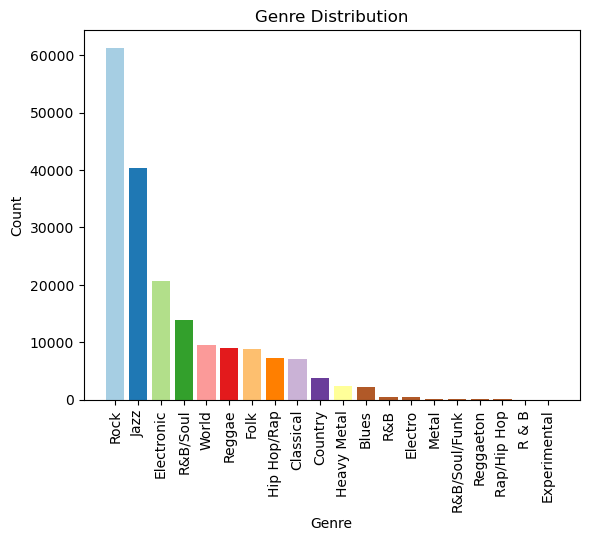

In [8]:
# Visualize genre distribution
genre_counts = df["Genre"].value_counts()
plt.title("Genre Distribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.bar(genre_counts.index, genre_counts, color=plt.cm.Paired(np.arange(len(genre_counts))))

# TODO: Combine genres


<Axes: >

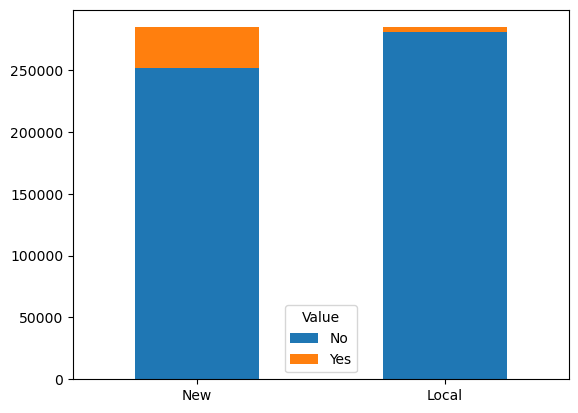

In [9]:
# Visualize local and new distributions
total_spins = df.shape[0]
num_new = df["New"].sum()
num_local = df["Local"].sum()
new_and_local = pd.DataFrame({"New": [total_spins - num_new, num_new],
                              "Local": [total_spins - num_local, num_local],
                              "Value": ["No", "Yes"]}).set_index("Value")
new_and_local.T.plot.bar(stacked=True, rot=0)
    

In [34]:
# Temporary add (for work below), until the feature is properly created via scraping
df["Top100"] = np.random.randint(0, 1, df.shape[0])


C:\Users\Zachary\AppData\Local\Temp\ipykernel_4148\639479631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Top100"] = np.random.randint(0, 1, df.shape[0])


In [36]:
def spins_to_dj(spin_df: pd.DataFrame):
    """
    df - a pandas DataFrame of Spinitron spin records
    Returns: a dataframe in dj format
    """
    # Begin a dataframe, where each row is indentified by dj name
    dj_df = spin_df.groupby(["DJ Name"]).count().reset_index()
    dj_df = dj_df[["DJ Name", "Playlist Title"]].rename(columns={"Playlist Title": "Total_Spins"})

    # Engineered Features: avg time of day (start time), avg duration, average # spins
    eng_df = spin_df[["DJ Name", "Playlist Title", "Playlist Duration", "Date", "Time"]]

    pattern = "%I:%M:%S %p"
    def to_min(x):
        time_extracted = datetime.strptime(x, pattern)
        return time_extracted.hour*60 + time_extracted.minute
    eng_df["Time"] = eng_df["Time"].apply(lambda x: to_min(x))
    start_times_df = eng_df.groupby(["DJ Name", "Date"]).min().reset_index()
    dj_df["Avg_Start"] = start_times_df[["DJ Name", "Time"]].groupby("DJ Name").mean().reset_index()["Time"]

    duration_df = eng_df[["DJ Name", "Playlist Duration"]]
    dj_df["Avg_Duration"] = duration_df.groupby("DJ Name").mean().reset_index()["Playlist Duration"]

    one_day_spin_count_df = spin_df.groupby(["DJ Name", "Date"]).count().reset_index()
    avg_spin_df = one_day_spin_count_df[["DJ Name", "Playlist Title"]].groupby("DJ Name").mean().reset_index()
    dj_df["Avg_Spins"] = avg_spin_df["Playlist Title"]

    # Populate genre count features
    genre_df = spin_df.dropna(subset=["Genre"]) # Temporary, until genre is filled completely
    genre_df = genre_df.groupby(["DJ Name", "Genre"]).count().reset_index()
    genre_df = genre_df[["DJ Name", "Genre", "Playlist Title"]].rename(columns={"Playlist Title": "genre_count"})
    genre_df = genre_df.pivot(index="DJ Name", columns="Genre", values="genre_count").fillna(0).reset_index()
    genre_df = genre_df.rename_axis(None, axis=1)
    dj_df = pd.merge(dj_df, genre_df, on="DJ Name", how='inner')

    # Count new music policy violations
    one_day_new_df = spin_df[["DJ Name", "Date", "New"]].groupby(["DJ Name", "Date"]).sum().reset_index()
    one_day_spin_count_df = one_day_spin_count_df[["DJ Name", "Date", "Playlist Title"]]
    one_day_spin_count_df = one_day_spin_count_df.rename(columns={"Playlist Title": "show_spins"})
    joined_new_df = pd.merge(one_day_new_df, one_day_spin_count_df, on=["DJ Name", "Date"], how='inner')
    joined_new_df["new_percent"] = joined_new_df["New"] / joined_new_df["show_spins"]
    joined_new_df["new_violations"] = (joined_new_df["new_percent"] < 0.25).astype(int)
    grouped_new_df = joined_new_df[["DJ Name", "new_violations"]].groupby("DJ Name").sum().reset_index()
    dj_df = pd.merge(dj_df, grouped_new_df, on="DJ Name", how='inner')

    # Count popular artist policy violations
    dj_df["top_violations"] = spin_df[["DJ Name", "Top100"]].groupby(["DJ Name"]).sum().reset_index()["Top100"]

    # Calculate policy violation feature
    dj_df["Violations"] = dj_df["new_violations"] + dj_df["top_violations"]
    dj_df = dj_df.drop(columns=["new_violations", "top_violations"])

    return dj_df

djs_df = spins_to_dj(spin_df=df)
djs_df

C:\Users\Zachary\AppData\Local\Temp\ipykernel_4148\2484322641.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_df["Time"] = eng_df["Time"].apply(lambda x: to_min(x))


,DJ Name,Total_Spins,Avg_Start,Avg_Duration,Avg_Spins,Blues,Classical,Country,Electro,Electronic,...,R & B,R&B,R&B/Soul,R&B/Soul/Funk,Rap/Hip Hop,Reggae,Reggaeton,Rock,World,Violations
0,Adam Higgins,1270,15.000000,129.448819,26.458333,2.0,319.0,2.0,0.0,620.0,...,0.0,0.0,77.0,0.0,0.0,0.0,0.0,42.0,6.0,3
1,Agent One,402,575.791667,81.343284,16.750000,0.0,0.0,3.0,0.0,10.0,...,0.0,0.0,10.0,0.0,0.0,0.0,0.0,250.0,5.0,12
2,Ava P,1676,960.160000,122.398568,33.520000,8.0,1.0,11.0,1.0,45.0,...,0.0,1.0,14.0,0.0,0.0,5.0,0.0,644.0,12.0,50
3,B. Stokes,621,948.526316,120.000000,32.684211,2.0,0.0,243.0,0.0,1.0,...,0.0,1.0,6.0,0.0,0.0,3.0,0.0,94.0,52.0,19
4,Babytooth,321,4.666667,163.551402,35.666667,0.0,1.0,1.0,1.0,27.0,...,0.0,0.0,8.0,0.0,0.0,3.0,0.0,66.0,3.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,lizard,640,944.181818,106.406250,19.393939,1.0,2.0,6.0,1.0,19.0,...,0.0,4.0,27.0,0.0,0.0,7.0,0.0,160.0,8.0,33
238,old greg,14,662.000000,60.000000,14.000000,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,1
239,otis cleveland,3866,1188.071856,127.853078,23.149701,153.0,204.0,86.0,2.0,98.0,...,0.0,3.0,126.0,0.0,0.0,27.0,0.0,469.0,346.0,150
240,syd,269,739.111111,120.000000,29.888889,1.0,0.0,0.0,0.0,16.0,...,0.0,0.0,66.0,0.0,0.0,0.0,0.0,135.0,2.0,4


In [121]:
def spins_to_shows(spin_df: pd.DataFrame):
    """
    df - a pandas DataFrame of Spinitron spin records
    Returns: a dataframe in spin format
    """
    
    dj_df = spin_df.groupby(["DJ Name", "Date"]).count().reset_index()
    dj_df = dj_df[["DJ Name", "Date", "Playlist Title"]].rename(columns={"Playlist Title": "Total_Spins"})

    one_day_new_df = spin_df[["DJ Name", "Date", "New"]].groupby(["DJ Name", "Date"]).sum().reset_index()
    dj_df = pd.merge(one_day_new_df, dj_df, on=["DJ Name", "Date"], how='outer')

    # Populate genre count features
    genre_df = spin_df.dropna(subset=["Genre"]) # Temporary, until genre is filled completely
    genre_df = genre_df.groupby(["DJ Name", "Date", "Genre"]).count().reset_index()
    genre_df = genre_df[["DJ Name", "Genre", "Playlist Title", "Date"]].rename(columns={"Playlist Title": "genre_count"})
    genre_df = genre_df.pivot(index=["DJ Name", "Date"], columns="Genre", values="genre_count").fillna(0).reset_index()
    genre_df = genre_df.rename_axis(None, axis=1)
    dj_df = pd.merge(dj_df, genre_df, on=["DJ Name", "Date"], how='outer')

    dj_df["new_percent"] = dj_df["New"] / dj_df["Total_Spins"]
    dj_df["new_violations"] = (dj_df["new_percent"] < 0.25).astype(int)

    # Count popular artist policy violations
    dj_df["artist_bb"] = spin_df[["DJ Name", "artistBB"]].groupby(["DJ Name"]).sum().reset_index()["artistBB"]
    dj_df["artist_violations"] = dj_df["artist_bb"] / dj_df["Total_Spins"]
    dj_df["popular_violations"] = (dj_df["artist_violations"] > 0.2).astype(int)
    

    dj_df["song_violations"] = spin_df[["DJ Name", "songBB"]].groupby(["DJ Name"]).sum().reset_index()["songBB"]

    # Calculate policy violation feature
    dj_df["Violations"] = dj_df["new_violations"] + dj_df["popular_violations"] + dj_df["song_violations"]

    
    return dj_df


small_djs = spins_to_shows(spin_df=small)
small_djs.fillna(0, inplace= True)
small_djs

# TODO: address the NaNs in data (should be 0s)

,DJ Name,Date,New,Total_Spins,0,Blues,Classical,Country,Electro,Electronic,...,Reggaeton,Rock,World,new_percent,new_violations,artist_bb,artist_violations,popular_violations,song_violations,Violations
0,Adam Higgins,2024-01-05,7,22,1.0,0.0,5.0,0.0,0.0,14.0,...,0.0,0.0,0.0,0.318182,0,0.0,0.000000,0,0.0,0.0
1,Adam Higgins,2024-01-12,8,24,1.0,0.0,8.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.333333,0,1.0,0.041667,0,0.0,0.0
2,Agent One,2024-01-03,0,14,8.0,0.0,0.0,0.0,0.0,2.0,...,0.0,1.0,0.0,0.000000,1,7.0,0.500000,1,0.0,2.0
3,Agent One,2024-01-10,0,13,8.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.000000,1,0.0,0.000000,0,0.0,1.0
4,Ava P,2024-01-02,0,29,8.0,0.0,0.0,0.0,0.0,2.0,...,0.0,5.0,0.0,0.000000,1,1.0,0.034483,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,glumbus,2024-01-06,0,28,18.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.000000,1,0.0,0.000000,0,0.0,0.0
156,glumbus,2024-01-13,0,20,9.0,1.0,0.0,0.0,0.0,1.0,...,0.0,2.0,1.0,0.000000,1,0.0,0.000000,0,0.0,0.0
157,otis cleveland,2024-01-02,0,34,7.0,0.0,2.0,1.0,0.0,0.0,...,0.0,4.0,2.0,0.000000,1,0.0,0.000000,0,0.0,0.0
158,otis cleveland,2024-01-09,0,37,10.0,4.0,0.0,1.0,0.0,1.0,...,0.0,4.0,2.0,0.000000,1,0.0,0.000000,0,0.0,0.0


## Data Modeling

#### Policy Violation Linear Regression

In [126]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score 
import datetime 
small_djs.columns 

Index([           'DJ Name',               'Date',                'New',
              'Total_Spins',                    0,              'Blues',
                'Classical',            'Country',            'Electro',
               'Electronic',       'Experimental',               'Folk',
              'Heavy Metal',        'Hip Hop/Rap',               'Jazz',
                    'R & B',                'R&B',           'R&B/Soul',
            'R&B/Soul/Funk',             'Reggae',          'Reggaeton',
                     'Rock',              'World',        'new_percent',
           'new_violations',          'artist_bb',  'artist_violations',
       'popular_violations',    'song_violations',         'Violations'],
      dtype='object')

In [127]:

small_djs["Date"] = pd.to_datetime(small_djs["Date"])
small_djs["Date"] = small_djs["Date"].map(datetime.datetime.toordinal)
small_djs.drop(0)
#X.columns = X.columns.astype(str) 


small_djs_X = small_djs.drop(["DJ Name", "New", "new_percent", "new_violations", "artist_bb", "artist_violations", "popular_violations", "song_violations", "Violations"], axis=1)
small_djs_Y = small_djs["Violations"]


small_djs_X_train = small_djs_X[:-20]
small_djs_X_test = small_djs_X[-20:]
small_djs_Y_train = small_djs_Y[:-20]
small_djs_Y_test = small_djs_Y[-20:]

regr = linear_model.LinearRegression()
regr.fit(small_djs_X_train, small_djs_Y_train)
small_djs_Y_pred = regr.predict(small_djs_X_test)
print("Coefficients: \n", regr.coef_)
print(f'Mean Squared Error: {mean_squared_error(small_djs_Y_test, small_djs_Y_pred)}')
print(f'R squared: {r2_score(small_djs_Y_test, small_djs_Y_train)}')

TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

#### DJ Clustering

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

DJ Name              DJ Llu
Total_Spins            6873
Avg_Start        881.157407
Avg_Duration     120.270624
Avg_Spins         31.819444
Blues                  14.0
Classical              38.0
Country                30.0
Electro                13.0
Electronic           1242.0
Experimental            0.0
Folk                   97.0
Heavy Metal             0.0
Hip Hop/Rap           477.0
Jazz                  292.0
Metal                   0.0
R & B                   0.0
R&B                     6.0
R&B/Soul              760.0
R&B/Soul/Funk           0.0
Rap/Hip Hop             0.0
Reggae                 69.0
Reggaeton               0.0
Rock                 2174.0
World                  47.0
Violations               33
Name: 73, dtype: object
DJ Name             JAH RED
Total_Spins            7277
Avg_Start        889.226054
Avg_Duration     124.089597
Avg_Spins         27.881226
Blues                   1.0
Classical               3.0
Country                 0.0
Electro                 

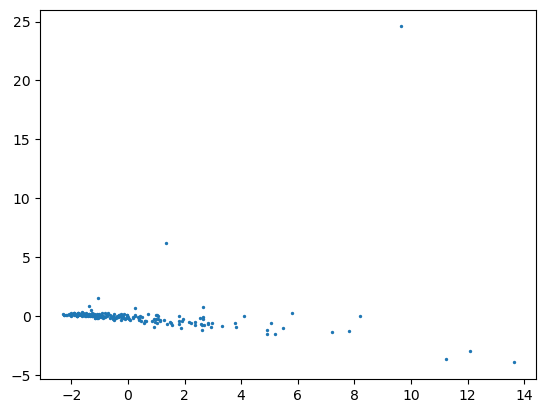

In [70]:
def dimension_reduction(high_dim_df: pd.DataFrame) -> np.ndarray:
    high_dim_df_numeric = high_dim_df[high_dim_df["DJ Name"] != "Program Director"]
    #high_dim_df_numeric = high_dim_df_numeric[high_dim_df["DJ Name"] != "JAH RED"]
    high_dim_df_numeric = high_dim_df_numeric.drop(columns=["DJ Name"])

    # Apply standard scalar
    scalar = StandardScaler()
    x = scalar.fit_transform(X=high_dim_df_numeric)

    """print(scalar.feature_names_in_)
    print(scalar.var_)

    fig, ax = plt.subplots()
    plt.bar(x=scalar.feature_names_in_, height=scalar.var_)
    ax.set_xticklabels(labels=scalar.feature_names_in_, rotation=90, fontsize=8)"""

    # Apply PCA
    pca = PCA(n_components=2)
    x = pca.fit_transform(x)

    max_x_idx = np.argmax(x[:, 0])
    max_y_idx = np.argmax(x[:, 1])
    print(high_dim_df.iloc[max_x_idx, :])
    print(high_dim_df.iloc[max_y_idx, :])

    return x

def visualize(viz_data: np.ndarray):
    x = viz_data[:, 0]
    y = viz_data[:, 1]
    plt.scatter(x, y, s=2)

data = dimension_reduction(djs_df)
visualize(data)

#### Hypothesis Testing